**INTRODUCTION**

  Have you ever posed a question to an AI language model like ChatGPT, hoping to learn about the latest advancements in a specific area, only to receive a response along the lines of, 'I'm sorry, but I'm unable to provide real-time updates or access current news. My knowledge is frozen in time, last updated in September 2021.' This limitation is inherent in large language models—they're essentially static repositories of information, incapable of learning or retaining new knowledge without undergoing a complex and time-consuming retraining process. In simpler terms, they're like time capsules, capturing knowledge up to a certain point but unable to keep up with ongoing developments.

 Now what if we could supplement their existing knowledge with up-to-date information, enabling them to provide more accurate and relevant responses without the need for extensive retraining?This is exactly what **Retrieval Augmented Generation (RAG)** does.

RAG has two components:



> ***RETRIEVER***: Retriever module is responsible for finding the most relevant information from a repository of information or dataset in response to user query.

>  ***GENERATOR***:
 Once the retriever identifies pertinent information, it must be relayed back to the application for presentation to the user. So, a generator is used to transform the retrieved data into understandable content suitable for humans.









***The Architecture of RAG: ***

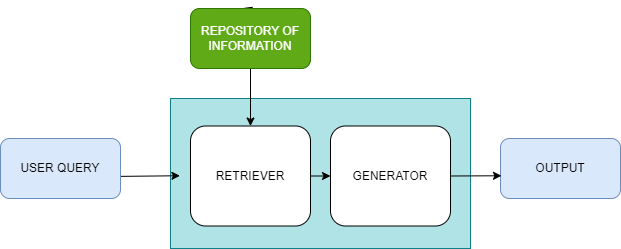



Below is the RAG process


> 1)A human asks a question of the LLM.

> 2)The RAG system looks up the repository of information (vector database) and extracts content that may be relevant.


> 3)The RAG system passes the user’s query, plus the additional content retrieved from the document store, to the LLM.


> 4)Now the LLM provides an answer that makes sense in the context of the content retrieved from the repository of information(vector database).


> 5)The RAG system returns the response from the LLM








  







Now that we have understood RAG.Let's go ahead and build a simple RAG system.


**Required Installations:**

**LANGCHAIN**  

> LangChain simplifies the development of applications leveraging language models by providing a framework for Python and TypeScript/JavaScript. With LangChain, developers can seamlessly chain together agents or tasks to interface with models, integrate with various data sources, including vector data stores, and manage data and model responses efficiently.

**FAISS**

> is an open-source library developed by Facebook AI Research (FAIR) for efficient similarity search and clustering of dense vectors. It's designed to handle large-scale datasets and is optimized for both memory usage and computational speed.






Below is the link on instructions of how to install FAISS

https://github.com/facebookresearch/faiss/blob/main/INSTALL.md

In [21]:
#Install the required libraries
!pip install -U  langchain
!pip install -U langchain_community
!pip install -U langchain_openai
!pip install faiss-cpu

**LOAD THE DOCUMENT:**

Now we need a document corpus.Here lets use a single document for simplicity.We are using stateOFTheUnion 2023 address by Joe Biden.You can replace it with any document you like.Below is the link from which you can download
https://images.idgesg.net/assets/2024/02/stateoftheunion2023.txt

We use **document loaders** in Langchain to load data from a source as Document's. A Document is a piece of text and associated metadata. For example, there are document loaders for loading a simple .txt file, for loading the text contents of any web page, or even for loading a transcript of a YouTube video.

In [22]:
from langchain_community.document_loaders import TextLoader
loader = TextLoader('./stateOfTheUnion2023.txt')

**SPLIT THE DATA:**

For large-scale datasets, we split text into smaller chunks  to improve the efficiency, scalability, and robustness of text processing tasks

In [23]:
from langchain.text_splitter import CharacterTextSplitter
documents = loader.load()
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
texts = text_splitter.split_documents(documents)

**CREATE A VECTOR DATABASE:**

Next step is to generate embeddings (vector representations) for text.We use an OpenAI default embedding model for this.

Post this we use FAISS to create a database from the text documents . FAISS is a library for efficient similarity search and indexing of high-dimensional vectors.

LangChain provides API functions to interact with FAISS.So create an OPENAI API KEY here https://platform.openai.com/api-keys
and paste it below

In [24]:
from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
import os
os.environ["OPENAI_API_KEY"] = "input Your api key here"

In [25]:
embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(texts, embeddings)

**RETRIEVER TOOL:**

we use LangChain to create a retriever for our vector database
The main things we need to pass in are a name for the retriever as well as a description

In [26]:
# We create a 'retriever' that knows how to interact with our vector database using an augmented context
retriever = db.as_retriever()
from langchain.agents.agent_toolkits import create_retriever_tool
tool = create_retriever_tool(
    retriever,
    "search_state_of_union",
    "Searches and returns documents regarding the state-of-the-union."
)
tools = [tool]

**GENERATOR:**

We wrap an LLM (here OpenAI) with a conversational interface that can process augmented requests

In [31]:
from langchain.agents.agent_toolkits import create_conversational_retrieval_agent
# LangChain provides an API to interact with chat models
from langchain_openai.chat_models import ChatOpenAI
llm = ChatOpenAI(temperature = 0)
agent_executor = create_conversational_retrieval_agent(llm, tools, verbose=True)



Next up .. we can use our LLM integrated with RAG

In [32]:
input = "what is NATO?"
result = agent_executor.invoke({"input": input})

# Response from the model

input = "When was it created?"
result = agent_executor.invoke({"input": input})

# Response from the model




> Entering new AgentExecutor chain...
NATO stands for the North Atlantic Treaty Organization. It is an intergovernmental military alliance between 30 North American and European countries. NATO's purpose is to guarantee the freedom and security of its members through political and military means. The alliance was established in 1949 and is based on the North Atlantic Treaty. NATO members commit to mutual defense in response to an attack by any external party.

> Finished chain.


> Entering new AgentExecutor chain...
NATO was created on April 4, 1949.

> Finished chain.


Now lets ask about the most recent happennings and see how our chatbot gives the relevant answer using RAG

In [34]:
input="what did the president say about inflation in the most recent state of the union?"
result = agent_executor.invoke({"input": input})
result["output"]



> Entering new AgentExecutor chain...
In the most recent State of the Union address, the President mentioned that inflation has been a global problem due to disruptions caused by the pandemic and external factors like Putin's war. However, the President also stated that inflation in the United States is coming down. The President highlighted the Inflation Reduction Act as a significant step to bring down healthcare costs and address the issue of high prescription drug prices.

> Finished chain.


"In the most recent State of the Union address, the President mentioned that inflation has been a global problem due to disruptions caused by the pandemic and external factors like Putin's war. However, the President also stated that inflation in the United States is coming down. The President highlighted the Inflation Reduction Act as a significant step to bring down healthcare costs and address the issue of high prescription drug prices."

**CONCLUSION**:


Utilizing a framework like LangChain significantly streamlines the initial stages of delving into Large Language Model (LLM) applications. Especially for beginners looking to experiment with basic examples, LangChain is highly recommended. It facilitates a direct dive into retrieval-augmented generation tasks, allowing users to focus on core functionalities such as document ingestion and interactions between the vector database and the LLM, rather than becoming entangled in technical complexities.

However, as you progress towards handling larger datasets and deploying applications in production, a more comprehensive exploration of local LLMs, vector databases, and embeddings becomes essential. This deeper understanding is crucial for optimizing performance and navigating the intricacies associated with managing extensive datasets and real-world deployment scenarios.


